In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("paper")
#Load Data
data = DataLoader("/export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5")

norm = image.norm
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.1, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.1, "upper": upper},
                    
}

# Define Model
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 2)

# Train Model
mm.fit(n_components=60, show_results = False)

File: /export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((12484,))
        Dataset: mass (float32) ((12484,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64, 64))
Creating datamatrix with the following fields:
Particle type:  stars
Fields:  ['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']
Dimension:  dim2
Default arguments are used for the fields that are not specified in the norm_fu

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import trange
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [80]:
class eigenNet(nn.Module):
    def __init__(self, eigengalaxies, means,input_field_index,num_fields = 3,hidden_layers = 7,
                 hidden_size = 128,activation = nn.ReLU(), dropout_prob = 0.1):
        super().__init__()
        self.eigengalaxies = eigengalaxies.view(eigengalaxies.size(0), num_fields * 64**2)
        self.eigen_field = eigengalaxies[:,input_field_index]
        self.mean_field = means[input_field_index]
        self.means = means.view(num_fields *64**2)
        self.input_field_index = input_field_index
        # Define the layers in the MLP
        # Define the layers in the MLP
        layers = []
        layers.append(nn.Linear(60, hidden_size))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_prob))  # Add a dropout layer

        # Add hidden layers
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_prob))  # Add a dropout layer

        # Add the output layer
        layers.append(nn.Linear(hidden_size, 60))

        # Create the MLP
        self.MLP = nn.Sequential(*layers)
     
    def encode(self,x):
        # project x onto the eigengalaxies
        # Flatten the input
        x = x.view(x.size(0), 64**2)
        x = x-self.mean_field
        latent = x @ self.eigen_field.T # x is now the latent space of dimension n_eigen
        latent = self.MLP(latent)
        return latent
    
    def decode(self,x):
        # reconstruct the image from the latent space with all eigengalaxies
        x = x @ self.eigengalaxies + self.means
        # Reshapes the output back to the original image shape
        x = x.view(x.size(0), 3, 64, 64)
        x = torch.sigmoid(x) # Sigmoid activation to normalize pixel values between 0 and 1
        return x


    def forward(self, x):
        latent = self.encode(x)
        return self.decode(latent)

In [3]:

img_size = 64 * 64  # Number of pixels in each image

eigen = torch.Tensor(mm.eigengalaxies).to(device).view(60,3,64*64)
means = torch.Tensor(mm.get_means()).to(device).view(3,64*64)


In [4]:
mm.inverse_transformed_datamatrix.shape

(12484, 12288)

In [15]:


# Step 3: Split the dataset into training and testing sets

# Step 4: Train the neural network




num_epochs = 1000

data = mm.datamatrix.reshape(12484, 3, 64, 64)
# data = data[:, 0, :]  # Use only the first map to learn the scores
targets = mm.scores

# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2, random_state=42)

# Assuming you have your training data and targets as tensors
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

test_data = torch.Tensor(test_data).to(device)
test_targets = torch.Tensor(test_targets).to(device)

# Convert test data and targets into a TensorDataset

# Convert training data and targets into a TensorDataset
train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)
# Define the batch size for training
batch_size = 64



# Create the train_loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [ ]:
def show(predicted_score=None, target_score=None, savepath=None, img_pred = None, img_true = None):
    reconstructed_images_pred = mm.reconstruct(predicted_score) if img_pred is None else img_pred
    reconstructed_images_target = mm.reconstruct(target_score) if img_true is None else img_true
    # Make residual plots for all 3 maps
    # Calculate residuals for each map
    residuals = reconstructed_images_pred - reconstructed_images_target

    reconstruction_error = np.median(residuals)
    # Plot the original images, reconstructed images, and residuals
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    # Iterate over the maps
    for i in range(3):
        # Plot original image
        axes[i, 0].imshow(reconstructed_images_target[i])
        axes[i, 0].set_title(f"Ground Truth Map {i+1}")
        # Plot reconstructed image from predicted scores
        axes[i, 1].imshow(reconstructed_images_pred[i])
        axes[i, 1].set_title(f"Reconstructed (Predicted) Map {i+1}")

        axes[i,2].imshow(residuals[i], cmap = "coolwarm")
        axes[i, 2].set_title(f"Residual {i+1}")
        # Set axis labels
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.savefig(savepath)
    plt.close("all")


In [87]:

log_file = "loss_log.txt"
# Create a new file for logging
with open(log_file, "w") as f:
    f.write("")
# Start training

lambda_scores_loss = 0
lambda_reconstruction_loss = 1



def loss_func(scores_pred, scores_target, img_pred, img_target):
    scores_loss = criterion(scores_pred, scores_target)
    reconstruction_loss = criterion(img_pred, img_target)
    # reconstruction_loss = nn.BCELoss()(img_pred, img_target)
    
    return lambda_scores_loss*scores_loss+lambda_reconstruction_loss*reconstruction_loss




train_loss = []
test_loss = []


input_field_index = 0

# decoder = Decoder(eigen, means)

model = eigenNet(eigen,means,activation=nn.ReLU(), input_field_index = input_field_index,
                 hidden_layers=10, hidden_size=60, dropout_prob=0.1).to(device)

criterion = nn.MSELoss().to(device)  # Use mean squared error as the loss function
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Add weight decay for regularization


for epoch in trange(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:  # Iterate over the training set
        inputs = inputs.to(device) #image
        targets = targets.to(device) #scores
        optimizer.zero_grad()
        input_img = inputs[:, input_field_index, :]
        input_img = input_img.view(-1, 1, 64*64)
        outputs = model(input_img) # images: (batch_size, 3, 64, 64)
        output_img_pred = outputs[:, input_field_index, :].view(-1, 1, 64*64)
        scores_pred = model.encode(input_img)
        loss = loss_func(scores_pred = scores_pred, scores_target = targets, img_pred = output_img_pred, img_target = input_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(train_loader)
    train_loss.append(average_loss)
    if epoch % 10 == 0:
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}\n")

        
     
    # Periodically compute and print the mean train and test loss
    if epoch % 10 == 0:
        test_loss_this_epoch = []

        # Set the model to evaluation mode
        model.eval()

        # Disable gradient calculation
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                input_img = inputs[:, 0, :]
                input_img = input_img.view(-1, 1, 64*64)
                outputs = model(input_img) # images: (batch_size, 3, 64, 64)
                output_img_pred = outputs[:, input_field_index, :].view(-1, 1, 64*64)
                scores_pred = model.encode(input_img)
                loss = loss_func(scores_pred = scores_pred, scores_target = targets, img_pred = output_img_pred, img_target = input_img)
                test_loss_this_epoch.append(loss.item())
            show(img_pred =outputs[0].detach().cpu().numpy(),target_score= targets[0].detach().cpu().numpy(), savepath=f"epochs/epoch_{epoch}.png")
            

        model.train()  # Set the model back to training mode

        test_loss_mean = torch.mean(torch.Tensor(test_loss_this_epoch)).item()
        test_loss.append(test_loss_mean)

        with open(log_file, "a") as f:
            f.write(f"Mean Test Loss: {test_loss[-1]:.2e}\n")

# Step 5: Evaluate the trained model
# Compute predicted PCA components for the testing set
# Compare predicted components with ground truth and calculate evaluation metrics


 18%|█▊        | 176/1000 [05:53<27:34,  2.01s/it]


KeyboardInterrupt: 

In [70]:
def evaluate(model, test_data, test_targets, batch_size=64):
    # Put the model in evaluation mode
    model.eval()

    # Create tensors for the test data
    test_data = torch.Tensor(test_data).to(device)
    test_targets = torch.Tensor(test_targets).to(device)

    # Create a test dataset
    test_dataset = TensorDataset(test_data, test_targets)

    # Create a test data loader
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Lists to store predicted PCA components
    pred_images = []

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move inputs to the GPU device
            inputs = inputs.to(device)
            inputs = inputs.view(-1, 1, 64*64)
            # Forward pass
            outputs = model(inputs)

            # Move outputs back to the CPU
            outputs = outputs.cpu().numpy()

            pred_images.append(outputs)

    # Concatenate predicted PCA components
    pred_images = np.concatenate(pred_images)
    return pred_images
def evaluate_prediction(predicted_image = None, true_image = None,predicted_score = None, target_score=None, index=None,plot = True):
    if target_score is not None:
        target_score= target_score.cpu().numpy()
    if predicted_score is not None:
        predicted_score = predicted_score[index]
        target_score = target_score[index]
    
    reconstructed_images_pred = mm.reconstruct(predicted_score) if predicted_score is not None else predicted_image[index]
    reconstructed_images_target = mm.reconstruct(target_score) if target_score is not None else true_image[index]
    # Make residual plots for all 3 maps
    # Calculate residuals for each map
    residuals = reconstructed_images_pred - reconstructed_images_target

    reconstruction_error = np.median(residuals)
    if not plot: return reconstruction_error
    # Plot the original images, reconstructed images, and residuals
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    # Iterate over the maps
    for i in range(3):
        # Plot original image
        axes[i, 0].imshow(reconstructed_images_target[i])
        axes[i, 0].set_title(f"Ground Truth Map {i+1}")
        # Plot reconstructed image from predicted scores
        axes[i, 1].imshow(reconstructed_images_pred[i])
        axes[i, 1].set_title(f"Reconstructed (Predicted) Map {i+1}")

        axes[i,2].imshow(residuals[i], cmap = "coolwarm")
        axes[i, 2].set_title(f"Residual {i+1}")

        
        

        # Set axis labels
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()
    print(f"Median reconstruction error: {reconstruction_error:.2f}%")
    return reconstruction_error

def continue_training(model, num_epochs):
    with open(log_file, "a") as f:
        f.write(f"------------Continuing training for {num_epochs} epochs----------------\n")
    model.train()
    for epoch in trange(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:  # Iterate over the training set
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        train_loss.append(average_loss)
        if epoch % 80 == 0:
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}\n")

        # Periodically compute and print the mean train and test loss
        if epoch % 10 == 0:
            test_loss_this_epoch = []

            # Set the model to evaluation mode
            model.eval()

            # Disable gradient calculation
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss_this_epoch.append(loss.item())

            model.train()  # Set the model back to training mode

            test_loss_mean = torch.mean(torch.Tensor(test_loss_this_epoch)).item()
            test_loss.append(test_loss_mean)

            with open(log_file, "a") as f:
                f.write(f"Mean Test Loss: {test_loss[-1]:.2e}\n")

    plt.plot(range(len(train_loss)), train_loss, label='Train Loss')
    plt.plot(range(10, num_epochs + 1, 10), test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [79]:
scores.min()

-0.3308254

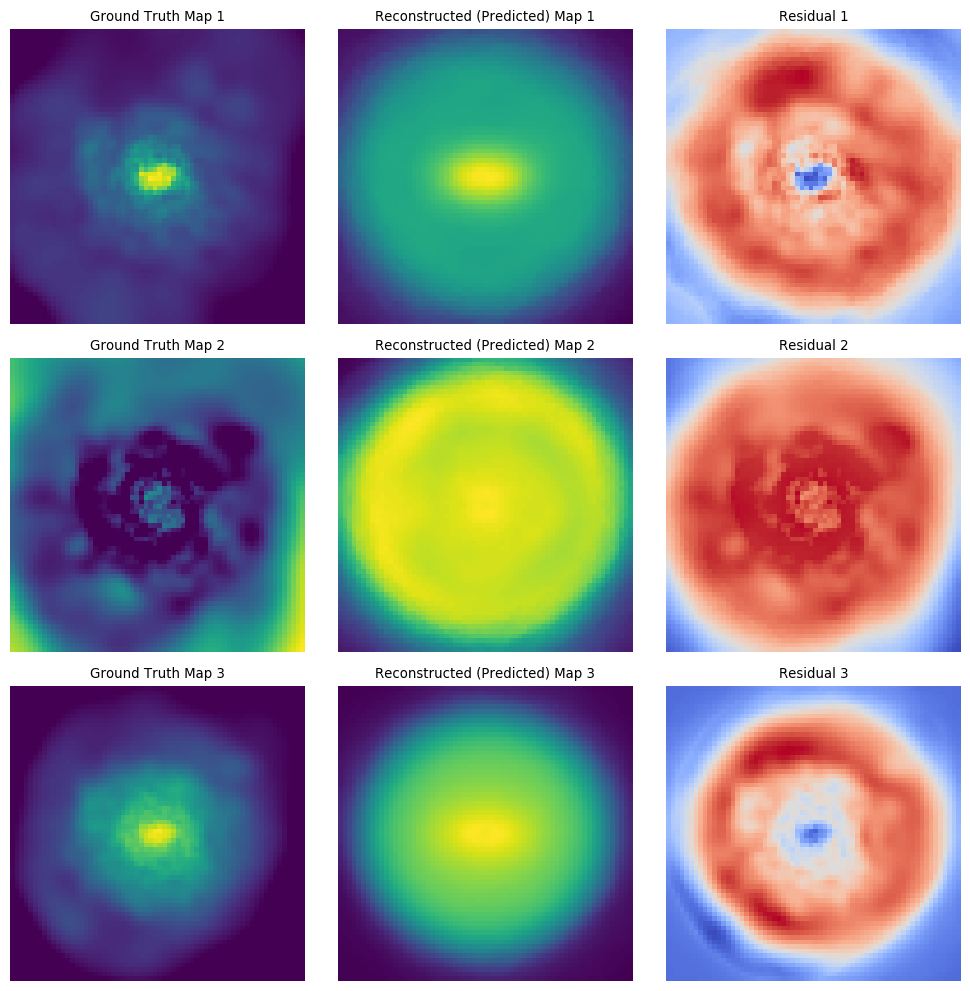

Median reconstruction error: 0.33%


0.33142778

In [77]:
scores = evaluate(model, test_data, test_targets)
evaluate_prediction(index = 6, predicted_image=scores, true_image=test_data.cpu().detach().numpy(),plot = True)